In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS = 3
EPOCHS = 100

In [3]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/eurosat-dataset/EuroSAT",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 27000 files belonging to 10 classes.


2022-12-19 05:20:26.187787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 05:20:26.284590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 05:20:26.285385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 05:20:26.290329: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
class_names = ds.class_names
class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

2022-12-19 05:20:28.982693: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 64, 64, 3)


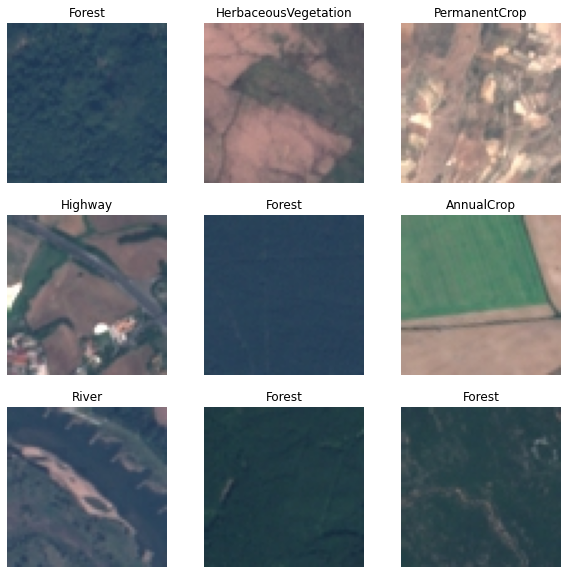

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in ds.take(1):
    print(image_batch.shape)
    for i in range(0,9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
len(ds)

844

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2)
])

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu',padding='same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',padding='same' ),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 64, 64, 3)           0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 64, 64, 3)           0         
_________________________________________________________________
conv2d (Conv2D)              (32, 64, 64, 32)          896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 32, 32, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 32, 32, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 16, 16, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 16, 16, 64)         

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/100


2022-12-19 05:20:43.133994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 76 of 10000
2022-12-19 05:20:53.173999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 155 of 10000
2022-12-19 05:21:03.217870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 229 of 10000
2022-12-19 05:21:13.126262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 315 of 10000
2022-12-19 05:21:23.115680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 404 of 10000
2022-12-19 05:21:33.150632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 493 of 10000
2022-12-19 05:21:43.182321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuf

670/675 [============================>.] - ETA: 0s - loss: 1.4525 - accuracy: 0.4316

2022-12-19 05:22:31.158359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 690 of 10000


675/675 [==============================] - 122s 26ms/step - loss: 1.4506 - accuracy: 0.4323 - val_loss: 1.0348 - val_accuracy: 0.6187


2022-12-19 05:22:32.950490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-12-19 05:22:32.951662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-12-19 05:22:32.952183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Epoch 2/100
675/675 [==============================] - 5s 8ms/step - loss: 0.9916 - accuracy: 0.6331 - val_loss: 0.8257 - val_accuracy: 0.6957
Epoch 3/100
675/675 [==============================] - 5s 8ms/step - loss: 0.8260 - accuracy: 0.7008 - val_loss: 0.7828 - val_accuracy: 0.7161
Epoch 4/100
675/675 [==============================] - 5s 8ms/step - loss: 0.7477 - accuracy: 0.7267 - val_loss: 0.7438 - val_accuracy: 0.7251
Epoch 5/100
675/675 [==============================] - 5s 8ms/step - loss: 0.6832 - accuracy: 0.7500 - val_loss: 0.7041 - val_accuracy: 0.7388
Epoch 6/100
675/675 [==============================] - 5s 8ms/step - loss: 0.6310 - accuracy: 0.7696 - val_loss: 0.7603 - val_accuracy: 0.7232
Epoch 7/100
675/675 [==============================] - 5s 7ms/step - loss: 0.5784 - accuracy: 0.7902 - val_loss: 0.5387 - val_accuracy: 0.7976
Epoch 8/100
675/675 [==============================] - 5s 8ms/step - loss: 0.5461 - accuracy: 0.8049 - val_loss: 0.5876 - val_accuracy: 0.7946

In [16]:
scores = model.evaluate(test_ds)

2022-12-19 05:34:20.105719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 750 of 10000


57/85 [===================>..........] - ETA: 0s - loss: 0.2039 - accuracy: 0.9243

2022-12-19 05:34:21.154603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-12-19 05:34:21.155753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-12-19 05:34:21.156230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


85/85 [==============================] - 11s 3ms/step - loss: 0.2222 - accuracy: 0.9232


In [17]:
scores

[0.22219251096248627, 0.9231617450714111]

In [18]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 675}

In [19]:
history.history["loss"]

[1.4506250619888306,
 0.9916106462478638,
 0.826047420501709,
 0.7477115392684937,
 0.683215320110321,
 0.6309674382209778,
 0.5783740878105164,
 0.5460726618766785,
 0.4986236095428467,
 0.4577346444129944,
 0.4408966302871704,
 0.4083065986633301,
 0.3983904719352722,
 0.37514325976371765,
 0.3605964779853821,
 0.3560531437397003,
 0.3338271975517273,
 0.3122057318687439,
 0.3199695944786072,
 0.30337250232696533,
 0.3041527569293976,
 0.2948448359966278,
 0.29232218861579895,
 0.27965253591537476,
 0.2728840112686157,
 0.2793605923652649,
 0.2617349624633789,
 0.25179868936538696,
 0.2505994737148285,
 0.2518649399280548,
 0.24429729580879211,
 0.24583278596401215,
 0.2384583204984665,
 0.2407694160938263,
 0.23680263757705688,
 0.23037515580654144,
 0.22791588306427002,
 0.21841560304164886,
 0.22665594518184662,
 0.21933972835540771,
 0.20992541313171387,
 0.2138054519891739,
 0.2127162218093872,
 0.2181120067834854,
 0.2134404331445694,
 0.206986203789711,
 0.2023095339536667,
 0

In [20]:
history.history["accuracy"]

[0.4322897493839264,
 0.6330585479736328,
 0.7008151412010193,
 0.726658046245575,
 0.7500463128089905,
 0.7695906162261963,
 0.7901537418365479,
 0.8048814535140991,
 0.823638379573822,
 0.8364672064781189,
 0.8455446362495422,
 0.8544831275939941,
 0.8605039119720459,
 0.8681918978691101,
 0.8741663694381714,
 0.873842179775238,
 0.8819933533668518,
 0.8890792727470398,
 0.8871804475784302,
 0.8936643004417419,
 0.8951926827430725,
 0.8976009488105774,
 0.900009274482727,
 0.9006113409996033,
 0.9038532972335815,
 0.9035754203796387,
 0.9073267579078674,
 0.9129307270050049,
 0.9121897220611572,
 0.913718044757843,
 0.9178862571716309,
 0.9156631827354431,
 0.9161726832389832,
 0.9152000546455383,
 0.9173768162727356,
 0.9198777079582214,
 0.9217765927314758,
 0.9241385459899902,
 0.9216839671134949,
 0.9244164228439331,
 0.9280288815498352,
 0.9271952509880066,
 0.9293720126152039,
 0.9233049154281616,
 0.9254353642463684,
 0.9275194406509399,
 0.9308540225028992,
 0.931502401828765

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

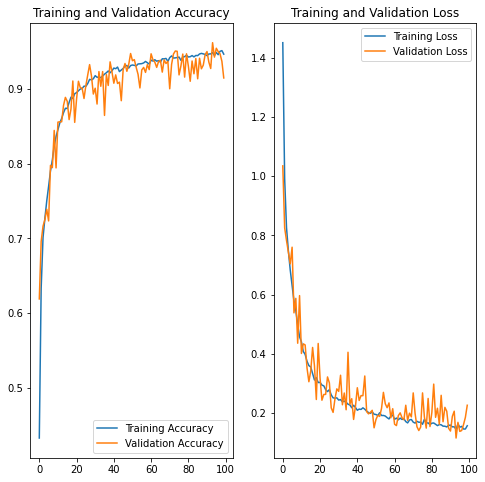

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()